# Enrichment Analysis

Enrichment analysis (EA) is a technique used to derive biological insight from lists of significantly altered genes. The list of genes can be obtained from Differential Expression (DE) analysis or users' interest. Then, the EA methods rely on the knowledge databases (e.g. KEGG and GO) to identify biological pathways or terms that are enriched in a gene list more than would be expected by chance. The outcome of the EA would be the in-depth and contextualized findings to help understand the mechanisms of disease, genes and proteins associated with the etiology of a specific disease or drug target.

Over more than a decade, there are over 50 methods have been developed for PA. In this module, we will focus on pathway analysis using three popular methods including Over Representation Analysis (ORA), Fast Gene Set Enrichment Analysis (FGSEA) and Gene Set Analysis (GSA).

## Learning Objectives:
1. Data preparation
2. Performing enrichment analysis using ORA, FGSEA and GSA
3. Visualizing and interpreting the outputs

## Gene mapping
In this module, we will use the DE genes with statistic generated in the [**Sub-module 02** ](./Module02-DE_Analysis.ipynb) using `limma` R package. We can use the following command to load DE analysis result.

In [251]:
DE.df <- readRDS("./data/DE_genes.rds")
rownames(DE.df) <- DE.df$PROBEID
head(DE.df)

,PROBEID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
222178_s_at,222178_s_at,-0.4473780,0.3653633,-73.01106,4.019112e-55,2.197450e-50,81.05538
224687_at,224687_at,-4.1431631,2.2572347,-48.92036,5.489424e-46,1.500671e-41,74.18354
207488_at,207488_at,-0.4017530,0.6243144,-39.29933,4.735684e-41,8.630785e-37,68.83493
239226_at,239226_at,0.4483302,1.3245501,28.36499,7.626558e-34,1.042455e-29,58.84908
234109_x_at,234109_x_at,-0.2289726,0.7508256,-27.67010,2.635337e-33,2.881741e-29,58.00438
212833_at,212833_at,-2.5976592,1.7308944,-24.01172,2.914912e-30,2.656213e-26,52.99567


We can see that the genes are saved with probe IDs, we need to convert them into gene symbols so that they can be analyzed using enrichment analysis method later in this module. We will use the same approach presented in the [**Sub-module 01** ](./Module01-GEO_Data_Processing.ipynb) with `hgu133plus2.db` and `AnnotationDbi` databases.

In [252]:
# Load the databases
suppressMessages({
  library(hgu133plus2.db)
  library(AnnotationDbi)
})

Then, we can retrieve vector of probe IDs to perform gene symbol mapping using the following command:

In [253]:
probeIDs = DE.df$PROBEID
suppressMessages({
annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID','GENENAME','SYMBOL'))
})
# View the first few genes in the mapping table
head(annotLookup)

,PROBEID,GENENAME,SYMBOL
,<chr>,<chr>,<chr>
1,222178_s_at,NA,NA
2,224687_at,ankyrin repeat and IBR domain containing 1,ANKIB1
3,207488_at,NA,NA
4,239226_at,NA,NA
5,234109_x_at,one cut homeobox 3,ONECUT3
6,212833_at,solute carrier family 25 member 46,SLC25A46


Now, we can merge DE data frame with annotation table by the `PROBEID` and remove NA gene symbols using the following command:

In [254]:
DE.df = merge(annotLookup, DE.df, by="PROBEID")

In [255]:
# Remove NA gene symbol
DE.df = DE.df[!is.na(DE.df$SYMBOL),]
# Remove duplicated genes
DE.df = DE.df[!duplicated(DE.df$SYMBOL,fromLast=FALSE),]
head(DE.df)

,PROBEID,GENENAME,SYMBOL,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1007_s_at,discoidin domain receptor tyrosine kinase 1,DDR1,-0.23858465,1.0967772,-2.08257585,0.04210211,0.2531265,-4.284228
2,1053_at,replication factor C subunit 2,RFC2,0.05830367,0.9657758,1.42311356,0.16052793,0.4674726,-5.359907
3,117_at,heat shock protein family A (Hsp70) member 6,HSPA6,-0.01138494,1.1501582,-0.08100885,0.93573821,0.9861536,-6.337785
4,121_at,paired box 8,PAX8,0.02301084,1.0581847,0.87166663,0.38729816,0.7236528,-5.968512
5,1255_g_at,guanylate cyclase activator 1A,GUCA1A,0.36999950,1.4080351,1.78615022,0.07976123,0.3351480,-4.812134
6,1294_at,ubiquitin like modifier activating enzyme 7,UBA7,-0.11221434,1.0859983,-1.61593670,0.11200995,0.3925252,-5.082923


At the result, we obtain the new DE table with two more columns containing gene names and gene symbols. The use of this DE table can be varied based on the selected enrichment analysis tools.

## Enrichment analysis using Over-representation Analysis
Over-representation analysis (ORA) is a statistical method that determines whether genes from pre-defined gent set of a specific GO term or KEGG pathway are presented more than they would be expected (over-represented) in a subset of your data. In our learning module, this subset refers to the list of DE gene generated from `limma` method. For each gene set, an enrichment *p-value* is calculated using the Binomial distribution, Hypergeometric distribution, the Fisher exact test, or the Chi-square test. Normally, Hypergeometric distribution is a popular approach used to calculate enrichment p-value. The formula can be presented as follows:

$$
     P(X\geq x) = 1 - P(X \leq x-1) = 1 - \sum\limits_{i=0}^{x-1}\frac{\hphantom{}{M \choose i }{N - M \choose n-i}}{N \choose n}
$$

where *N* is the number of background genes (all genes presented in the expression matrix), *n* is the number of “interesting” genes (DE genes), *M* is the number of genes that are annotated to a particular gene set *S* (list of genes in a specific KEGG pathway or GO term), and *x* is the number of “interesting” genes that are annotated to *S* (genes presented in DE genes list and a specific KEGG pathway or GO term).

For example, suppose we have an expression matrix with 20000 genes, of which 500 are differently expressed. Also suppose that 100 of the 20000 genes are annotated to a particular gene set S. Of these 100 genes, 20 are members of DE genes list. The probability that 20 or more (up to 100) genes annotated to S are in DE genes list by chance is given by

$$
P(X\geq 20) = 1 - P(X \leq 19) = 1-\sum \limits_{i=0}^{19}\frac{\hphantom{}{100 \choose i}{20000 - 100 \choose 500-i}}{20000 \choose 500} = 5.26 \times 10^{-13}
$$

The *p-value* indicates it is very rare to observe 20 of the 100 genes from this set are in the DE genes list by chance.

### Data preparation
To conduct enrichment analysis using ORA, there are several input data that we need to prepare. First, we need to select a set of genes that
are significantly altered (*p-value < 0.05*) in the DE genes generated from `limma` method.

In [256]:
# Selecting a list of significant DE genes
DEGenes <- DE.df[DE.df$adj.P.Val <= 0.05,]
# Select genes with symbol
DEGenes <- DEGenes$SYMBOL

Next, we need to define a list of background genes. In this analysis, they are all the genes generated from the DE analysis.

In [257]:
#Defining background genes
backgroundSet <- DE.df$SYMBOL

Then, we need to obtain a list of geneset from knowledge databases such as GO and KEGG. In this learning module, the geneset will be retrieved from
the *.gmt* files that were processed from the [**Sub-module 03 - Gene Set and Pathway** ](./Module03-Gene_Set_and_Pathway.ipynb). To load the geneset, we will use `gmt2geneset`
below:

In [ ]:
# install tidyverse
suppressWarnings({
  install.packages("tidyverse")
})

In [260]:
# Loading tidyverse library that provides a function to read the .gmt file
suppressMessages({
  library(tidyverse)
})

In [261]:
# A customized function to prase a gmt file to a list of genesets
gmt2geneset <- function(path){
  genesets <- read_tsv(path, col_names = F) %>% apply(MARGIN = 1, function(r){
    genes = unique(r[-(1:2)])
    list(
      id = r[1],
      description = r[2],
      genes = genes[!is.na(genes)]
    )
  })

  gs <- lapply(genesets, function(g) g$genes %>% as.character())
  names(gs) <- lapply(genesets, function(g) g$description)
  gs
}

Here, we also write a function to perform over representation analysis based on the hyper-geometric testing formula presented above. The `ORA` method will perform
hyper-geometric testing for each geneset obtained from GO or KEGG using the function `phyper` available for `stats` R base package. The output of the `ORA` function is the table that
contains a column of term or pathway names and a column of *p-value*.

In [262]:
ORA <- function(geneset,DEGenes,backgroundSet,DE.df){
    res <- sapply(geneset, function(gs){
    wBallDraw <- intersect(gs, DEGenes) %>%  length() - 1
    if (wBallDraw < 0) return(1)
    wBall <- length(DEGenes)
    bBall <- nrow(DE.df) - length(DEGenes)
    ballDraw <- length(intersect(gs, backgroundSet))
    1 - phyper(wBallDraw, wBall, bBall, ballDraw)
  })
  res
}

### Enrichment analysis using ORA and GO terms
In this section, we will perform ORA using genesets obtained from the GO database and the function `ORA` defined above. The detailed code is presented below:

In [275]:
# Loading geneset from GO database
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# Perform ORA
res.ORA <- ORA(geneset,DEGenes,backgroundSet,DE.df)
# Save the result to a table where the first column is GO term name and the second column is the p-value
res.df <- data.frame(
  GOterms = names(res.ORA),
  pvalue = res.ORA
)
# Order the table based on the p-value
res.df <- res.df[order(res.df$pvalue),]
# View the most significant GO terms
head(res.df)

,GOterms,pvalue
,<chr>,<dbl>
positive regulation of B cell activation,positive regulation of B cell activation,0.0005237933
inner dynein arm assembly,inner dynein arm assembly,0.0010578236
cell activation involved in immune response,cell activation involved in immune response,0.0062357297
leukocyte activation involved in immune response,leukocyte activation involved in immune response,0.0062357297
immunoglobulin production involved in immunoglobulin-mediated immune response,immunoglobulin production involved in immunoglobulin-mediated immune response,0.0062357297
positive regulation of leukocyte activation,positive regulation of leukocyte activation,0.0062357297


Fromt the result table we might conclude that the cause of the disease may be related to `positive regulation of B cell activation`.

### Enrichment analysis using ORA and KEGG pathways

In [237]:
# Loading the KEGG pathways
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})

In [238]:
# Perform Hyper-geometric testing
res.ORA <- ORA(geneset,DEGenes,backgroundSet,DE.df)
# Save the results to a data frame
res.df <- data.frame(
  pathways = names(res.ORA ),
  pvalue = res.ORA
)

res.df <- res.df[order(res.df$pvalue),]
head(res.df)

,pathways,pvalue,pvalue.adj
,<chr>,<dbl>,<dbl>
Glycolysis / Gluconeogenesis - Homo sapiens (human),Glycolysis / Gluconeogenesis - Homo sapiens (human),0.5265186,1
Citrate cycle (TCA cycle) - Homo sapiens (human),Citrate cycle (TCA cycle) - Homo sapiens (human),0.2916326,1
Pentose phosphate pathway - Homo sapiens (human),Pentose phosphate pathway - Homo sapiens (human),0.2916326,1
Pentose and glucuronate interconversions - Homo sapiens (human),Pentose and glucuronate interconversions - Homo sapiens (human),1.0000000,1
Fructose and mannose metabolism - Homo sapiens (human),Fructose and mannose metabolism - Homo sapiens (human),1.0000000,1
Galactose metabolism - Homo sapiens (human),Galactose metabolism - Homo sapiens (human),0.2997330,1


## Enrichment Analysis using FGSEA

This Sub-Module describes FGSEA, one of the methods for evaluating pathway enrichment in transcriptional data and it stands for Fast preranked Gene Set Enrichment Analysis (GSEA). FGSEA quickly calculates arbitrarily low GSEA P-values for a collection of gene sets and is based on an algorithm that allows  it to make more permutations and get accurate *p-values*.
It extends the GSEA algorithm which Calculates the Enrichment Score (the degree to which a set S is over-represented at the top or bottom of the ranked list L), estimates the p-value of the Enrichment Score using a permutation test and adjusts the estimated significance level to account for multiple hypothesis in addition to calculating the q-values for FDR control. Typically, GSEA requires inputs of a list of gene sets (GO term or pathway with a set of genes), a vector DE genes with statistic. In addition, user can limit the number of terms or pathways of interest by adjusting `minSize` and `maxSize` parameters. The code to install and lost FGSEA R package is shown below:

In [39]:
# To perform enrichment analysis using FGSEA, we first install the fgsea package
suppressMessages({if (!require("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
  suppressWarnings(BiocManager::install("fgsea", update = F))
})

# Loading the package
suppressPackageStartupMessages({
  library("fgsea")
})

Next, we need to prepare a vector of DE genes with its statistic.

In [277]:
# Get the gene list and their statistic from DE results
stats = DE.df$adj.P.Val
names(stats) = DE.df$SYMBOL
head(stats)

DDR1      RFC2     HSPA6      PAX8    GUCA1A      UBA7 
0.2531265 0.4674726 0.9861536 0.7236528 0.3351480 0.3925252

In [278]:
### Enrichment analysis using FGSEA and GO terms

The package `fgsea` has its own function named `gmtPathways` to load the genesets from the `gmt` file. It is recommended to use this function for compatibility. We can load
GO terms geneset and view the first five GO terms with associated genes using the following command:

In [279]:
# Load the pathways into a named list
GO_term_hallmark <- gmtPathways("./data/GO_terms.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(GO_term_hallmark,head)
tmp[1:5]

$`GO:0000002`
[1] "AKT3"   "DNA2"   "DNAJA3" "ENDOG"  "FLCN"   "LIG3"  

$`GO:0000003`
[1] "A1CF"  "A2M"   "AAAS"  "ABAT"  "ABCC8" "ABHD2"

$`GO:0000012`
[1] "APLF"  "APTX"  "ERCC6" "ERCC8" "LIG4"  "PARP1"

$`GO:0000018`
[1] "ACTB"   "ACTL6A" "ACTR2"  "ALYREF" "ANKLE1" "APLF"  

$`GO:0000027`
[1] "BOP1"    "BRIX1"   "DDX28"   "DHX30"   "FASTKD2" "MDN1"

Running the FGSEA can be done by calling the `fgsea` with two required inputs.

In [280]:
# Running fgsea
suppressWarnings(fgseaRes <- fgsea(pathways = GO_term_hallmark,
                  stats    = stats
                  ))

The output of the FGSEA method is a table where row are GO terms IDs or pathway IDs. The columns are *p-values*, *adjusted p-values*, *Enrichment Score*, etc.

In [281]:
head(fgseaRes[order(pval), ][,-8])

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GO:0050907,1.968725e-05,0.1352120,0.5756103,0.3786406,1.568009,132
GO:0009593,5.079400e-05,0.1744266,0.5573322,0.3526733,1.483964,167
GO:0050911,8.742501e-05,0.1853031,0.5384341,0.3926074,1.589368,94
GO:0006959,1.144982e-04,0.1853031,0.5384341,0.3160059,1.367381,271
GO:0030850,1.349032e-04,0.1853031,0.5188481,0.4585205,1.756128,51
GO:0050906,1.983859e-04,0.2270857,0.5188481,0.3274274,1.393866,202


From the result table, we can select top five up regulated GO terms and top five down regulated GO terms. Then we can plot them using the built-in function `plotGseaTable`

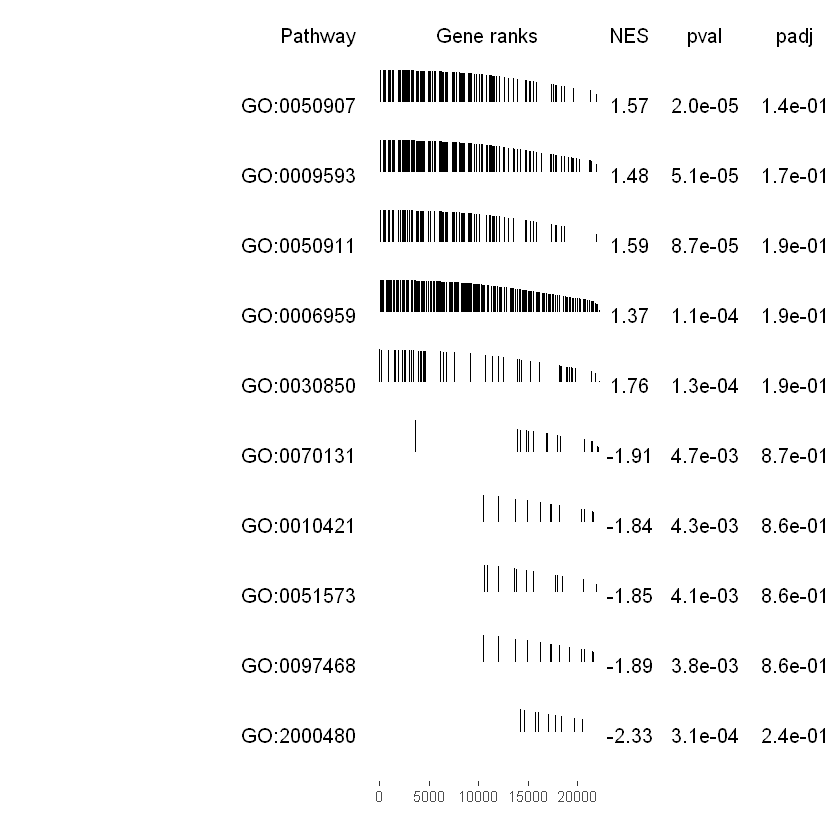

In [284]:
topGOUp <- fgseaRes[ES > 0][head(order(pval), n=5), pathway]
topGODown <- fgseaRes[ES < 0][head(order(pval), n=5), pathway]
topGO <- c(topGOUp, rev(topGODown))
plotGseaTable(GO_term_hallmark[topGO], stats, fgseaRes,
              gseaParam=0.5)

### Enrichment analysis using FGSEA and KEGG pathways
We can perform enrichment analysis using FGSEA with KEGG pathway using the same procedure mentioned above. The only thing we need to change is the
list of geneset that available in KEGG database.

In [47]:
# Load the pathways into a named list
KEGG_hallmark <- gmtPathways("./data/KEGG_pathways.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(KEGG_hallmark,head)
tmp[1:5]

$hsa00010
[1] "HK3"   "HK1"   "HK2"   "HKDC1" "GCK"   "GPI"  

$hsa00020
[1] "CS"   "ACLY" "ACO2" "ACO1" "IDH1" "IDH2"

$hsa00030
[1] "GPI"  "G6PD" "PGLS" "H6PD" "PGD"  "RPE" 

$hsa00040
[1] "GUSB"    "KL"      "UGT2A1"  "UGT2A3"  "UGT2B17" "UGT2B11"

$hsa00051
[1] "MPI"   "PMM2"  "PMM1"  "GMPPB" "GMPPA" "GMDS"

In [48]:
# Running fgsea
suppressWarnings(fgseaRes <- fgsea(pathways = KEGG_hallmark,
                  stats    = stats))

In [49]:
head(fgseaRes[order(pval), ][,-8])

pathway,pval,padj,log2err,ES,NES,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
hsa05168,2.251489e-13,7.159734e-11,0.9436322,0.3559273,1.589161,468
hsa04060,1.086974e-12,1.728289e-10,0.9101197,0.3884407,1.702789,291
hsa04151,3.327686e-10,3.527347e-08,0.8140358,0.3566070,1.574856,353
hsa04530,1.870476e-09,1.487029e-07,0.7749390,0.4137364,1.760410,164
hsa04510,2.323402e-08,1.477684e-06,0.7337620,0.3850561,1.658695,199
hsa05202,7.078569e-08,3.751641e-06,0.7049757,0.3821628,1.642714,188


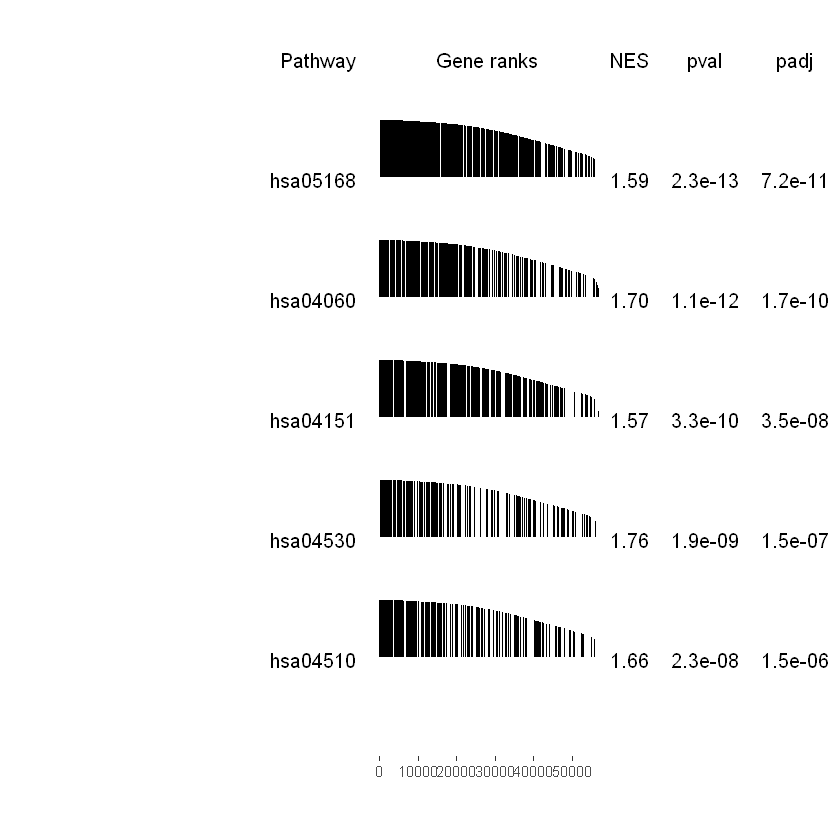

In [50]:
topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n=5), pathway]
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n=5), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
#Viewing the 5 most significantly up-regulated and down-regulated pathways each with the FGSEA internal plot function
plotGseaTable(KEGG_hallmark[topPathways], stats, fgseaRes,
              gseaParam=0.5)

## Gene Set Enrichment Analysis using GSA

This submodule explains Gene Set Analysis (GSA), an Enrichment Analysis, a method that is commonly used to summarize high-dimensional gene expression data sets into sets according to its biological relevance. GSA takes the ranked gene lists from the initial stage of a gene expression analysis and aggregates the genes into sets based on shared biological or functional properties as specified by a reference knowledge base. Such databases often contain phenotype associations, molecular interactions and regulation and are referenced in the analysis of the resultant gene sets to find the relevance of the gene properties to the phenotype of interest.

### Data preparation
The GSA method is freely available as standalone package in CRAN repository. We can use the following code to install the package.

In [176]:
# Install GSA from CRAN
suppressMessages({if (!require("GSA"))
        suppressWarnings(install.packages("GSA"))
})
suppressMessages({
  library(GSA)
})

The GSA method require an expression matrix, a numeric vector containing class of each sample and a vector of genes the inputs. We can easily get those inputs by load the data that we processed in the [**Sub-module 01** ](./Module01-GEO_Data_Processing.ipynb).

In [178]:
# Loading expression data with groups
data <- readRDS("./data/GSE48350.rds")
expression_data <- data$expression_data
norm_expression_data <- data$norm_expression_data
groups <- data$groups

We can also use the sample approach available in the [**Sub-module 01** ](./Module01-GEO_Data_Processing.ipynb) to map the probe IDs to gene symbols. The step-by-step coding instruction is shown below:

In [179]:
# Get the probe IDs
expression_data$PROBEID <- rownames(expression_data)
probeIDs <- rownames(expression_data)
# Perform gene mapping
suppressMessages({
  annotLookup <- AnnotationDbi::select(hgu133plus2.db, keys = probeIDs, columns = c('PROBEID', 'GENENAME', 'SYMBOL'))
})
# Merge DE result  data frame with annotation table
new_expression_data = merge(annotLookup, expression_data, by="PROBEID")
# Remove NA value
new_expression_data <- new_expression_data[!is.na(new_expression_data$SYMBOL),]
# Remove duplicated genes symbol
new_expression_data <-  new_expression_data[!duplicated(new_expression_data$SYMBOL,fromLast=FALSE),]
rownames(new_expression_data) <- new_expression_data$SYMBOL
# Drop PROBEID, GENENAME, and SYMBOL columns
new_expression_data <- new_expression_data[,-c(1:3)]
genenames= rownames(new_expression_data)

### GSA Enrichment analysis using GO terms
Using data obtaiend from the previous step, we can run the GSA method by callinf the function `GSA`. We can reuse `GO_term_hallmark` and `KEGG_hallmark` loaded in FGSEA to perform analysis. The code details are shown below:

In [61]:
# Getting
genesets = GO_term_hallmark
GSA.obj<-GSA(as.matrix(new_expression_data),as.numeric(groups$groups), genenames=genenames, genesets=genesets, resp.type="Two class unpaired")

perm= 10 / 200 
perm= 20 / 200 
perm= 30 / 200 
perm= 40 / 200 
perm= 50 / 200 
perm= 60 / 200 
perm= 70 / 200 
perm= 80 / 200 
perm= 90 / 200 
perm= 100 / 200 
perm= 110 / 200 
perm= 120 / 200 
perm= 130 / 200 
perm= 140 / 200 
perm= 150 / 200 
perm= 160 / 200 
perm= 170 / 200 
perm= 180 / 200 
perm= 190 / 200 
perm= 200 / 200 


In [62]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj, geneset.names=names(genesets),FDRcut=.5)

A table of the negative gene sets. “Negative” means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. Eg for two classes coded 1,2, lower expression correlates with class 2.

In [63]:
neg.table <-res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
55,GO:0000422,-0.5436,0,0
620,GO:0006091,-0.4743,0,0
724,GO:0006418,-0.9139,0,0
783,GO:0006595,-0.4823,0,0
784,GO:0006596,-0.5397,0,0
785,GO:0006605,-0.4504,0,0
983,GO:0007029,-0.4715,0,0
986,GO:0007032,-0.5574,0,0
988,GO:0007034,-0.3837,0,0
1129,GO:0007528,-0.5997,0,0


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y.

In [64]:
pos.table <-res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
926,GO:0006911,0.5136,0,0
1115,GO:0007422,0.361,0,0
1688,GO:0014037,0.6887,0,0
1689,GO:0014044,0.95,0,0
1740,GO:0014912,0.5144,0,0
1885,GO:0017145,0.5955,0,0
2021,GO:0021533,0.5946,0,0
2048,GO:0021692,0.662,0,0
2049,GO:0021694,0.8817,0,0
2100,GO:0022011,1.0103,0,0


In [65]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(10, genesets, GSA.obj, genenames)

Gene,Score
CEBPA,1.553
NAGS,0.686
OTC,0.396
ORC1,0.2
CPS1,-0.097
ARG1,-0.632
SLC25A2,-0.782
ORC2,-0.872
ASL,-0.893
ASS1,-1.177


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"15 y values <= 0 omitted from logarithmic plot"


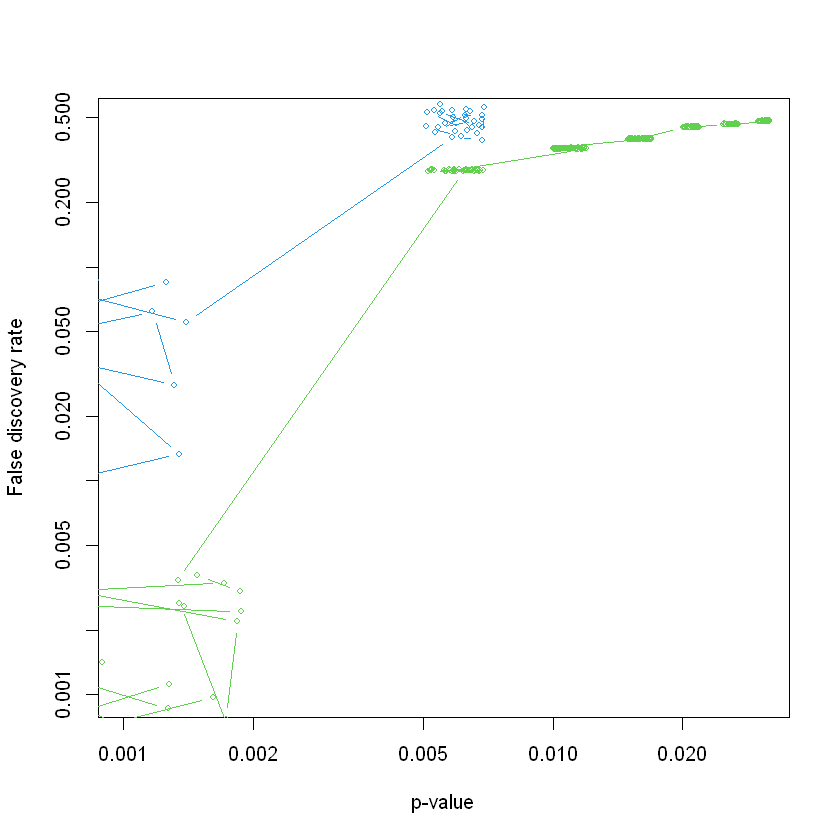

In [66]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac=1, FDRcut = 0.5))

### GSA Enrichment analysis using KEGG pathways
We can use the same procedure to per enrichment analyis with KEGG pathway. All the codes are similar but `genesets` are assigned from `KEGG_hallmark`. The code is shown below.

In [77]:
genesets = KEGG_hallmark
GSA.obj<-GSA(as.matrix(new_expression_data),as.numeric(groups$groups), genenames=genenames, genesets=genesets, resp.type="Two class unpaired", nperms=100)

perm= 10 / 100 
perm= 20 / 100 
perm= 30 / 100 
perm= 40 / 100 
perm= 50 / 100 
perm= 60 / 100 
perm= 70 / 100 
perm= 80 / 100 
perm= 90 / 100 
perm= 100 / 100 


In [78]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj, geneset.names=names(genesets),FDRcut=.5)

A table of the negative gene sets. "Negative" means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. Eg for two classes coded 1,2, lower expression correlates with class 2.

In [79]:
neg.table <-res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
212,hsa04723,-0.709,0,0
81,hsa00970,-0.8369,0.01,0.3988
163,hsa04260,-0.6792,0.01,0.3988
210,hsa04721,-0.6379,0.01,0.3988
246,hsa04932,-0.6199,0.01,0.3988
271,hsa05016,-0.7232,0.01,0.3988
274,hsa05022,-0.5238,0.01,0.3988
348,hsa05415,-0.6449,0.01,0.3988
15,hsa00190,-1.0546,0.02,0.4253
135,hsa04070,-0.3497,0.02,0.4253


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

In [80]:
pos.table <-res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
179,hsa04520,0.4948,0,0
223,hsa04810,0.1843,0,0


In [81]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(10, genesets, GSA.obj, genenames)

Gene,Score
ALDH9A1,2.707
HADHA,1.725
ACADVL,1.609
ADH1B,1.513
HADHB,1.175
ACAA1,0.79
ALDH2,0.768
ACSBG1,0.73
ALDH3A2,0.726
ACSL1,0.662


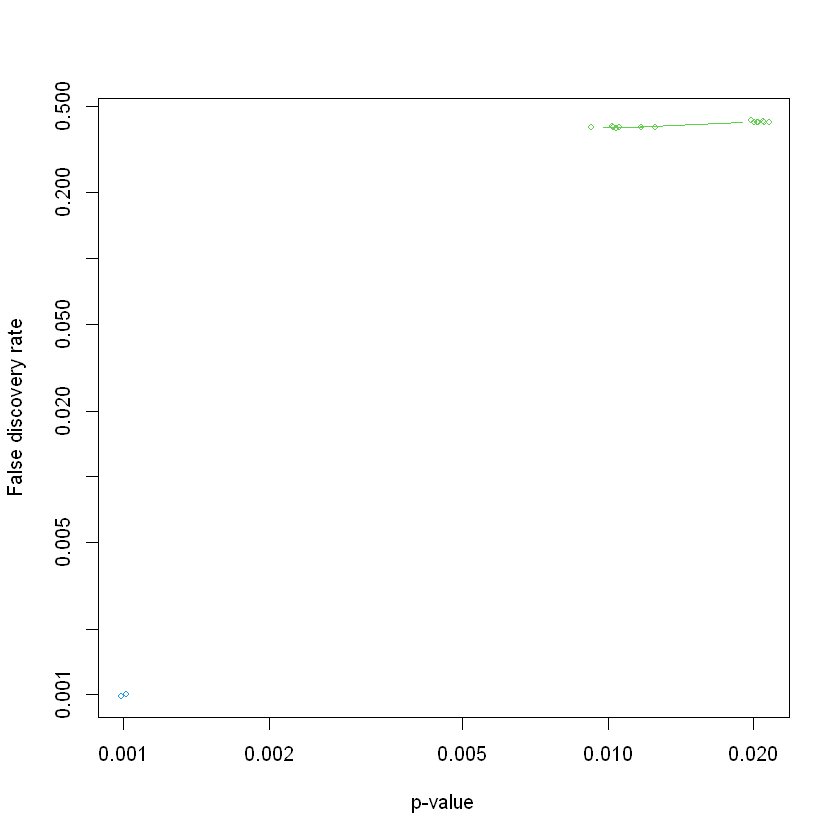

In [82]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac=1, FDRcut = 0.5))
